# 1. Library Imports

In [ ]:
# Library Imports & initializations
import os
import random
import shutil
import time
import math
import yaml
import colorsys  # For color conversions (HSV, RGB)
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
from IPython.display import display  # for displaying images

from google.colab import files, drive
drive.mount('/content/drive')  # allows Colab to import files from Google Drive

# Converts time (in sec) to hr:min:sec format
def convertTime(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Create Dataset: Generate images & YAML file

In [ ]:
def generate_images(num_images, output_folder):
    image_size = (640, 640)  # Size of the output image (in pixels)
    shapes_per_image = (1, 20)  # Range for the random number of shapes per image (min, max)
    shape_size = 75  # Base size of the shapes (both squares and circles)
    size_deviation_percentage = 25  # Deviation percentage for shape sizes--- 0
    rotation_deviation = 90  # Max angle of object rotation--- 0
    saturationRange = (0.5, 1.0)  # Saturation range for colors--- (1,1)
    valueRange = (0.5, 1.0)  # Value (brightness) range for colors--- (1,1)
    buffer = 1  # Buffer of 1 pixel around shapes (ensures shape isn't cut off by image edge)
    allowed_overlap_percentage = 60 #50  # Maximum allowed overlap percentage per shape--- 0

    # Calculate size deviation range
    min_size = shape_size * (1 - size_deviation_percentage / 100)
    max_size = shape_size * (1 + size_deviation_percentage / 100)

    # Dataset split ratios
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1

    # Calculate the number of images for each set
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val  # Ensure total sums up

    # Create directories for images and labels
    split_dirs = ['train', 'val', 'test']
    for split in split_dirs:
        images_dir = os.path.join(output_folder, 'images', split)
        labels_dir = os.path.join(output_folder, 'labels', split)
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

    progStartTime = time.time()
    num_generated_images = 0  # Number of images successfully generated
    i = 1  # Image index for filenames

    # Determine the splits for each image
    splits = ['train'] * num_train + ['val'] * num_val + ['test'] * num_test
    random.shuffle(splits)  # Shuffle to randomize the distribution

    while num_generated_images < num_images:
        imageStartTime = time.time()
        # Create a white background image
        img = Image.new('RGB', image_size, color='white')
        draw = ImageDraw.Draw(img)

        # Create a mask to keep track of occupied pixels
        mask = Image.new('L', image_size, 0)  # Black mask image
        mask_draw = ImageDraw.Draw(mask)

        # Random number of squares and circles
        num_squares = random.randint(*shapes_per_image)
        num_circles = random.randint(*shapes_per_image)

        # List to store annotations for YOLO format
        annotations = []

        success = True  # Flag to check if all shapes were placed successfully

        # Draw squares
        for _ in range(num_squares):
            result = draw_shape(
                img=img,
                mask=mask,
                draw=draw,
                mask_draw=mask_draw,
                shape_type='square',
                class_id=0,
                hue=240 / 360,  # Blue
                min_size=min_size,
                max_size=max_size,
                rotation_deviation=rotation_deviation,
                saturationRange=saturationRange,
                valueRange=valueRange,
                buffer=buffer,
                annotations=annotations,
                image_size=image_size,
                max_attempts=1000,
                allowed_overlap_percentage=allowed_overlap_percentage
            )
            if not result:
                success = False
                print("Could not place a square after max attempts. Retrying image...")
                break  # Exit the loop
        if not success:
            continue  # Discard the image and retry

        # Draw circles
        for _ in range(num_circles):
            result = draw_shape(
                img=img,
                mask=mask,
                draw=draw,
                mask_draw=mask_draw,
                shape_type='circle',
                class_id=1,
                hue=0 / 360,  # Red
                min_size=min_size,
                max_size=max_size,
                rotation_deviation=0,  # Circles don't need rotation
                saturationRange=saturationRange,
                valueRange=valueRange,
                buffer=buffer,
                annotations=annotations,
                image_size=image_size,
                max_attempts=1000,
                allowed_overlap_percentage=allowed_overlap_percentage
            )
            if not result:
                success = False
                print("Could not place a circle after max attempts. Retrying image...")
                break  # Exit the loop
        if not success:
            continue  # Discard the image and retry

        # Determine the split for this image
        split = splits[num_generated_images]
        images_dir = os.path.join(output_folder, 'images', split)
        labels_dir = os.path.join(output_folder, 'labels', split)

        # Save the image with the required filename & format
        filename = f"image_{i}_squares_{num_squares}_circles_{num_circles}.png"
        image_filepath = os.path.join(images_dir, filename)
        img.save(image_filepath, "PNG")

        # Save the annotations to a label file in YOLO format
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_filepath = os.path.join(labels_dir, label_filename)
        with open(label_filepath, 'w') as f:
            for annotation in annotations:
                f.write(annotation + '\n')

        imageTime = time.time() - imageStartTime
        print(f"Saved: {image_filepath} , Generated in: {imageTime:.2f}s")

        num_generated_images += 1
        i += 1  # Increment image index

    progTime = time.time() - progStartTime
    print(f"{num_images} images generated in {progTime:.2f}s, or {progTime/num_images:.4f} sec/img")
    # Create the data.yaml file
    create_data_yaml(output_folder)

def draw_shape(img, mask, draw, mask_draw, shape_type, class_id, hue, min_size, max_size,
               rotation_deviation, saturationRange, valueRange, buffer,
               annotations, image_size, max_attempts=1000, allowed_overlap_percentage=15):
    attempts = 0
    while attempts < max_attempts:
        # Random size and rotation
        shape_size_current = random.uniform(min_size, max_size)
        rotation_angle = random.uniform(0, rotation_deviation) if rotation_deviation > 0 else 0

        # Generate random color shade
        saturation = random.uniform(*saturationRange)
        value = random.uniform(*valueRange)
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        fill_color = (
            int(r * 255),
            int(g * 255),
            int(b * 255)
        )

        # Create a mask for the shape
        shape_mask = Image.new('L', image_size, 0)
        shape_mask_draw = ImageDraw.Draw(shape_mask)

        if shape_type == 'square':
            # Compute half size for convenience
            half_size = shape_size_current / 2

            # Compute the coordinates of the square before rotation (centered at origin)
            square_coords = [
                (-half_size, -half_size),
                (half_size, -half_size),
                (half_size, half_size),
                (-half_size, half_size)
            ]

            # Rotate the coordinates
            angle_rad = math.radians(rotation_angle)
            cos_theta = math.cos(angle_rad)
            sin_theta = math.sin(angle_rad)
            rotated_coords = []
            for x, y in square_coords:
                x_rot = x * cos_theta - y * sin_theta
                y_rot = x * sin_theta + y * cos_theta
                rotated_coords.append((x_rot, y_rot))

            # Adjust position ranges to ensure the entire rotated square fits within the image
            min_x = buffer + max(-min(coord[0] for coord in rotated_coords), 0)
            max_x = image_size[0] - buffer - max(coord[0] for coord in rotated_coords)
            min_y = buffer + max(-min(coord[1] for coord in rotated_coords), 0)
            max_y = image_size[1] - buffer - max(coord[1] for coord in rotated_coords)

            if min_x >= max_x or min_y >= max_y:
                attempts += 1
                continue  # Cannot place shape, try again

            x_center = random.uniform(min_x, max_x)
            y_center = random.uniform(min_y, max_y)

            # Final coordinates after shifting to (x_center, y_center)
            final_coords = [(x_center + x, y_center + y) for x, y in rotated_coords]

            # Draw the shape on the shape_mask
            shape_mask_draw.polygon(final_coords, fill=255)

            # Calculate overlapping area
            overlap_percentage = calculate_overlap_percentage(mask, shape_mask)

            if overlap_percentage <= allowed_overlap_percentage:
                # Draw the rotated square on the main image
                draw.polygon(final_coords, fill=fill_color)
                # Update the mask
                mask.paste(shape_mask, (0, 0), shape_mask)

                # Get axis-aligned bounding box
                xs = [coord[0] for coord in final_coords]
                ys = [coord[1] for coord in final_coords]
                bbox_left = min(xs)
                bbox_top = min(ys)
                bbox_right = max(xs)
                bbox_bottom = max(ys)

                # Calculate normalized coordinates for YOLO format
                x_center_norm = (bbox_left + bbox_right) / 2 / image_size[0]
                y_center_norm = (bbox_top + bbox_bottom) / 2 / image_size[1]
                width_norm = (bbox_right - bbox_left) / image_size[0]
                height_norm = (bbox_bottom - bbox_top) / image_size[1]

                annotations.append(f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}")

                return True  # Successfully placed the shape
            else:
                attempts += 1
                continue  # Overlaps too much, try again

        elif shape_type == 'circle':
            # Adjust position ranges
            min_x = buffer
            max_x = image_size[0] - shape_size_current - buffer
            min_y = buffer
            max_y = image_size[1] - shape_size_current - buffer

            if min_x >= max_x or min_y >= max_y:
                attempts += 1
                continue  # Cannot place shape, try again

            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)

            shape_area = (x, y, x + shape_size_current, y + shape_size_current)

            # Draw the shape on the shape_mask
            shape_mask_draw.ellipse(shape_area, fill=255)

            # Calculate overlapping area
            overlap_percentage = calculate_overlap_percentage(mask, shape_mask)

            if overlap_percentage <= allowed_overlap_percentage:
                # Draw the circle on the main image
                draw.ellipse(shape_area, fill=fill_color)
                # Update the mask
                mask.paste(shape_mask, (0, 0), shape_mask)

                # Calculate normalized coordinates for YOLO format
                x_center = (x + shape_size_current / 2) / image_size[0]
                y_center = (y + shape_size_current / 2) / image_size[1]
                width_norm = shape_size_current / image_size[0]
                height_norm = shape_size_current / image_size[1]

                annotations.append(f"{class_id} {x_center} {y_center} {width_norm} {height_norm}")

                return True  # Successfully placed the shape
            else:
                attempts += 1
                continue  # Overlaps too much, try again

    return False  # Could not place the shape after max_attempts

def calculate_overlap_percentage(existing_mask, shape_mask):
    # Convert masks to numpy arrays
    existing_mask_array = np.array(existing_mask, dtype=np.uint8)
    shape_mask_array = np.array(shape_mask, dtype=np.uint8)

    # Calculate the overlapping area
    overlap = np.logical_and(existing_mask_array > 0, shape_mask_array > 0)
    overlap_area = np.sum(overlap)

    # Calculate the total area of the shape
    shape_area = np.sum(shape_mask_array > 0)

    # Calculate the overlap percentage
    if shape_area == 0:
        return 100  # Prevent division by zero; treat as full overlap
    overlap_percentage = (overlap_area / shape_area) * 100

    return overlap_percentage

In [ ]:
# Function to create data.yaml
def create_data_yaml(output_folder):
    data = {
        'train': os.path.join(output_folder, 'images', 'train'),
        'val': os.path.join(output_folder, 'images', 'val'),
        'test': os.path.join(output_folder, 'images', 'test'),
        'nc': 2,
        'names': ['square', 'circle'] #the object classes, starting from "0"
    }

    yaml_content = f"""
train: {data['train']}
val: {data['val']}
test: {data['test']}

nc: {data['nc']}
names: {data['names']}
"""

    yaml_filepath = os.path.join(output_folder, 'data.yaml')
    with open(yaml_filepath, 'w') as f:
        f.write(yaml_content.strip())
    print(f"data.yaml file created at {yaml_filepath}")


# 3. Visualise Dataset

In [ ]:
def visualize_annotations(image_path, label_path, class_names):
    # Define colors for each class
    colors = ['blue', 'red', 'green', 'yellow', 'purple']  # Extend as needed for num of classes

    # Open the image
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Read the annotation file
    with open(label_path, 'r') as f:
        annotations = f.readlines()

    # Loop over each annotation
    for annotation in annotations:
        annotation = annotation.strip()
        if annotation == '':
            continue
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        # Convert normalized coordinates back to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the top-left corner of the bounding box
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        # Create a rectangle patch with the class-specific color
        color = colors[int(class_id) % len(colors)]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

        # Add class label text with matching color
        class_label = class_names[int(class_id)]
        plt.text(x_min, y_min - 10, class_label, color=color, fontsize=12, weight='bold', backgroundcolor='white')

    plt.axis('off')
    plt.show()

In [ ]:
def preview_dataset(output_directory, num_images_to_display):
    # Load data.yaml
    data_yaml_path = os.path.join(output_directory, 'data.yaml')
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    # Extract class names
    class_names = data['names']

    # Extract paths for each split
    splits = {}
    for split in ['train', 'val', 'test']:
        if split in data:
            splits[split] = data[split]

    for split_name, images_dir in splits.items():
        print(f'Displaying images from {split_name} set:')
        # images_dir is obtained from data.yaml
        # Get the labels directory path by replacing 'images' with 'labels' in the path
        labels_dir = images_dir.replace('images', 'labels')

        # Get a list of image files
        image_files = sorted(os.listdir(images_dir))

        # Display up to num_images_to_display images
        for image_file in image_files[:num_images_to_display]:
            image_path = os.path.join(images_dir, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(labels_dir, label_file)

            # Check if the label file exists
            if not os.path.exists(label_path):
                print(f'Annotation file {label_path} not found.')
                continue

            # Visualize the image with annotations
            print(f'Displaying {image_file}:')
            visualize_annotations(image_path, label_path, class_names)

# Main Program

Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/val/image_1_squares_18_circles_3.png , Generated in: 0.11s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/train/image_2_squares_3_circles_18.png , Generated in: 0.06s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/test/image_3_squares_7_circles_1.png , Generated in: 0.04s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/train/image_4_squares_20_circles_20.png , Generated in: 0.10s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/val/image_5_squares_15_circles_8.png , Generated in: 0.07s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/test/image_6_squares_9_circles_13.png , Generated in: 0.06s
Saved: /content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/images/train/image_7_squares_7_circles_14.png , Generated in: 0.06s
Saved: /content/dri

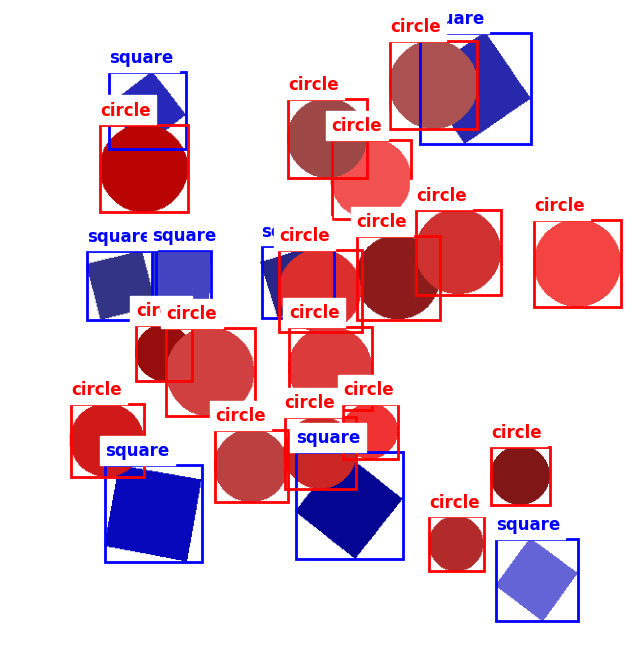

Displaying image_1001_squares_18_circles_1.png:


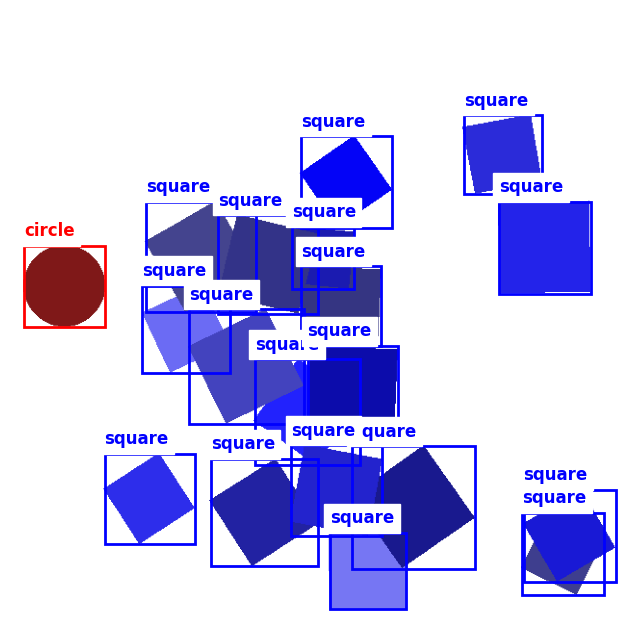

Displaying images from val set:
Displaying image_1002_squares_1_circles_16.png:


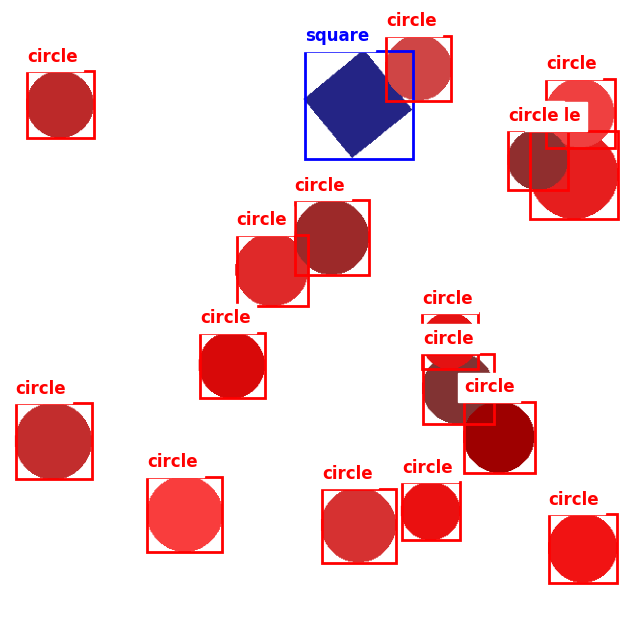

Displaying image_1012_squares_20_circles_12.png:


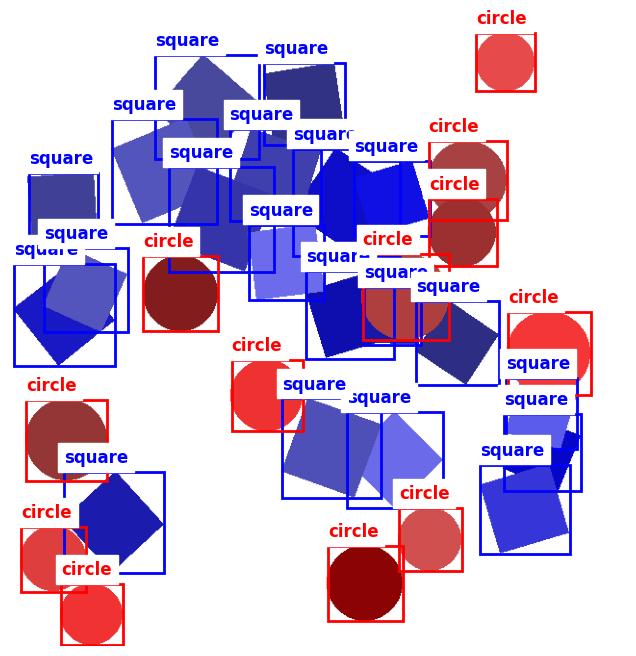

Displaying images from test set:
Displaying image_1004_squares_6_circles_9.png:


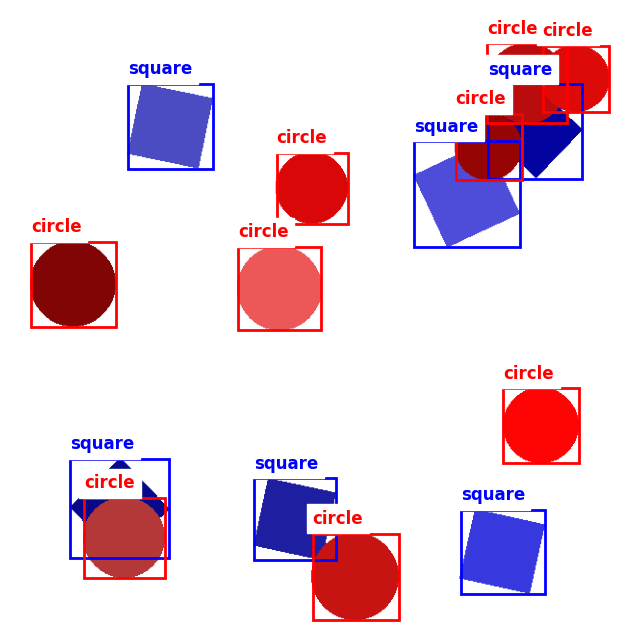

Displaying image_1007_squares_9_circles_12.png:


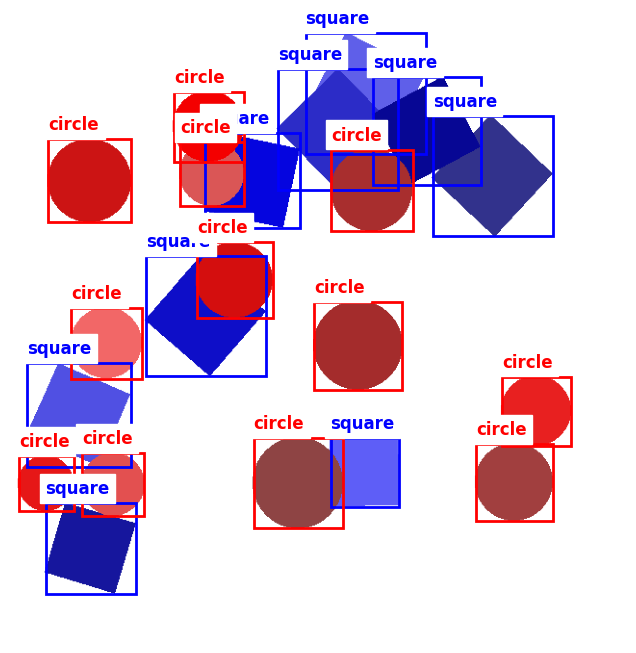

In [ ]:
# Main Program
createDataset = True
runModel = True
num_images_to_generate = 2000  # The number of image files to generate

personal = True
if personal == True:
    file_directory = "/content/drive/MyDrive/Colab Notebooks/ML Project"  # Only defines file locations, nothing else
    iteration = "YOLO overlap_60"  # Defines name of exact folder to use
else:
    file_directory = "/content/drive/MyDrive/Colab Notebooks/ML Project"  # Only defines file locations, nothing else
    iteration = "T1"  # Defines name of exact folder to use

output_directory = os.path.join(file_directory, iteration)
os.makedirs(output_directory, exist_ok=True)  # if directory doesn't exist, it will create it
if createDataset == True:
  if os.path.exists(output_directory):  # if the directory exists, existing contents will be deleted
      shutil.rmtree(output_directory)
  generate_images(num_images_to_generate, output_directory) #runs YOLO dataset creation program
  preview_dataset(output_directory, 2) #previews images w/ annotations, number of images to display

# Model

In [ ]:
if runModel:
  resultsOverwrite = True #subsiquent runs will overwrite old runs in same folder
  confThresh = 0.85 #prediction confidence threshold
  IOU_THRESHOLD = 0.7 # Define the IoU threshold for matching predictions to ground truths (default=0.7)

  !pip install ultralytics  # install library (UNCOMMENT on 1st run)----------------------------------------------------------------------------------------------------
  from ultralytics import YOLO, checks

  checks()  # checks
  resultsDir = os.path.join(output_directory, "Results")
  os.makedirs(resultsDir, exist_ok=True) #makes directory, or leaves it unaltered if it exists
  if resultsOverwrite:
      shutil.rmtree(resultsDir)

  progStartTime = time.time()
  model = YOLO("yolo11n.pt")  # Load a pretrained model
  train = model.train(data=os.path.join(output_directory, "data.yaml"), project=resultsDir, name="Training", epochs=60, patience=5, batch=32, dropout=0.2, plots=True) # train the model | batch=16
  metrics = model.val(split="test", project=resultsDir, name="Predictions", conf=confThresh, iou=IOU_THRESHOLD, plots=True, save_json=True, save_txt=True, save_conf=True) #Prediction using test data
  pred = model.predict(source=os.path.join(output_directory, "images/test"), project=os.path.join(resultsDir,"Predictions"), name="PredImages", conf=confThresh, iou=IOU_THRESHOLD, save=True) # predict

  progTime = time.time() - progStartTime
  print(f"Model train, val, pred in {convertTime(progTime)}")
  #model.info() #print model summary
  #print("Detailed Model Summary by layer:")
  #print(model)

Ultralytics 8.3.41 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 32.7/112.6 GB disk)


100%|██████████| 5.35M/5.35M [00:00<00:00, 154MB/s]


Ultralytics 8.3.41 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/data.yaml, epochs=60, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Colab Notebooks/ML Project/YOLO overlap_60/Results, name=Training, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

100%|██████████| 755k/755k [00:00<00:00, 100MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

# Extract Results (saved to files)

In [ ]:
#Functions for reading & interpreting results - All so that the program outputs an output message of where a prediciton mistake occured

def read_labels(file_path, is_prediction=False):
    """
    Reads labels from a text file.
    Args:
        file_path (str): Path to the label file.
        is_prediction (bool): Flag indicating if the labels are predictions.
    Returns:
        List of dictionaries containing class_id, box coordinates, and confidence (if prediction).
    """
    labels = []
    if not os.path.isfile(file_path):
        return labels  # Return empty list if file does not exist
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                box = convert_to_xyxy(x_center, y_center, width, height)
                label = {'class_id': class_id, 'box': box}
                if is_prediction and len(parts) == 6:
                    confidence = float(parts[5])
                    label['confidence'] = confidence
                labels.append(label)
    return labels

def convert_to_xyxy(x_center, y_center, width, height):
    """
    Converts normalized bounding box coordinates from (x_center, y_center, width, height)
    to (x_min, y_min, x_max, y_max).
    """
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return [x_min, y_min, x_max, y_max]

def compute_iou(boxA, boxB):
    """
    Computes Intersection over Union (IoU) between two bounding boxes.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def match_predictions_to_ground_truths(predictions, ground_truths):
    """
    Matches predictions to ground truths based on IoU.
    Returns matched indices and unmatched predictions and ground truths.
    """
    matches = []
    unmatched_predictions = []
    unmatched_ground_truths = []

    gt_matched = [False] * len(ground_truths)
    pred_matched = [False] * len(predictions)

    for i, pred in enumerate(predictions):
        best_iou = 0.0
        best_j = -1
        for j, gt in enumerate(ground_truths):
            iou = compute_iou(pred['box'], gt['box'])
            if iou >= IOU_THRESHOLD and iou > best_iou and not gt_matched[j]:
                best_iou = iou
                best_j = j
        if best_j >= 0:
            matches.append((i, best_j))
            pred_matched[i] = True
            gt_matched[best_j] = True
        else:
            unmatched_predictions.append(i)

    unmatched_ground_truths = [j for j, matched in enumerate(gt_matched) if not matched]
    return matches, unmatched_predictions, unmatched_ground_truths

In [ ]:
#Script that Extracts results for prediction mistakes & saves the results in a txt and csv file

labels_dir = os.path.join(output_directory, "labels", "test")
predictions_dir = os.path.join(resultsDir, "Predictions", "labels")

image_ids = [os.path.splitext(f)[0] for f in os.listdir(predictions_dir) if f.endswith('.txt')] # Get list of image IDs (filenames without extensions)
class_names = model.names # Get class names from the model
Incorrect_classification = 0
False_Positive = 0
Missed_Detection = 0

out_txtFile = os.path.join(resultsDir, "Predictions","PredictionErrors.txt")  # txt file name for specifics on every missed prediction
out_csvFile = os.path.join(resultsDir, "Predictions","PredictionError_Summary.csv")  # csv file name for summations on cumilituve predictions errors

with open(out_txtFile, 'w') as f:  # Open the file for writing
  for image_id in image_ids:
      gt_file = os.path.join(labels_dir, f"{image_id}.txt")
      pred_file = os.path.join(predictions_dir, f"{image_id}.txt")

      # Read ground truth and prediction labels
      ground_truths = read_labels(gt_file)
      predictions = read_labels(pred_file, is_prediction=True)

      # Match predictions to ground truths
      matches, unmatched_predictions, unmatched_ground_truths = match_predictions_to_ground_truths(predictions, ground_truths)

      # Process matched predictions
      for pred_idx, gt_idx in matches:
          pred_label = predictions[pred_idx]['class_id']
          gt_label = ground_truths[gt_idx]['class_id']
          if pred_label != gt_label:
             print(f"Image ID: {image_id} - Incorrect classification: Actual = {class_names[gt_label]} vs. Predicted = {class_names[pred_label]}", file=f)
             Incorrect_classification += 1

      # Process unmatched predictions (False Positives)
      for idx in unmatched_predictions:
          pred_label = predictions[idx]['class_id']
          print(f"Image ID: {image_id} - False Positive: Actual = Background  vs. Predicted = {class_names[pred_label]}", file=f)
          False_Positive += 1

      # Process unmatched ground truths (False Negatives)
      for idx in unmatched_ground_truths:
          gt_label = ground_truths[idx]['class_id']
          print(f"Image ID: {image_id} - Missed Detection: Actual = {class_names[gt_label]} vs. Predicted = Background", file=f)
          Missed_Detection += 1
  Total_Errors = Incorrect_classification + False_Positive + Missed_Detection
  Accuracy = (num_images_to_generate - Total_Errors)/num_images_to_generate
  print(f"Incorrect classifications: {Incorrect_classification} ; False Positives: {False_Positive} ; Missed Detections: {Missed_Detection} ; Total Errors: {Total_Errors} ; Accuracy: {Accuracy}", file=f)
f.close()

# Load the training log
results = pd.read_csv(os.path.join(resultsDir, "Training", "results.csv"))
results.columns = results.columns.str.strip() # Strip spaces
results["fitness"] = results["metrics/mAP50(B)"] * 0.1 + results["metrics/mAP50-95(B)"] * 0.9 # Calculate fitness
best_epoch = results['fitness'].idxmax() + 1 # Find the epoch with the highest fitness

with open(out_csvFile, 'w', newline='') as csvfile:  # Open the CSV file for writing
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Trial/Iteration','Incorrect classifications', 'False Positives', 'Missed Detections', 'Total Errors', 'Accuracy', 'Runtime', 'Best Epoch']) # Write the header row
    csvwriter.writerow([iteration, Incorrect_classification, False_Positive, Missed_Detection, Total_Errors, Accuracy, round(progTime,3), best_epoch]) # Write the data row
csvfile.close()